In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing as pre
from keras.models import load_model
import seaborn as sns

In [2]:
def build_autoencoder(neurons_in=28, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    # Input layer
    input_layer = keras.layers.Input(shape=(88,))

    l1_encoded = keras.layers.Dense(28, activation='relu', name='l1')(input_layer)
    # Bottleneck layer
    encoded = keras.layers.Dense(neurons_in, activation='relu', name='bottleneck')(l1_encoded)

    l1_decoded = keras.layers.Dense(28, activation='relu', name='l2')(encoded)
    # Output layer
    decoded = keras.layers.Dense(88, activation=act_function, name='decoded')(l1_decoded)

    # Create the model
    autoencoder = keras.Model(inputs=input_layer, outputs=[decoded,encoded])
    autoencoder.compile(loss=["binary_crossentropy","mse"], optimizer=optimizer, loss_weights=[1,0.6])

    return autoencoder

def train_autoencoder(emotion,data_t,data_v, index):

    callbacks = [
        keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
        )
    ]
    ae = build_autoencoder(2,"sigmoid","adam",0)
    _X_train = data_t[index]
    _X_val = data_v[index]


    history = ae.fit(_X_train[0],_X_train,
            validation_data = (_X_val[0],_X_val),
            epochs=5000,
            batch_size=128,
            verbose=0,
            callbacks = callbacks)


    return ae


def get_representations_re(autoencoder_to_test, encoders, test):

    lab = []

    res = (encoders[autoencoder_to_test].predict(test[autoencoder_to_test], verbose = False))
        # print(len(test[i]))


    features = np.array(res)
    return features


In [25]:
def mean_diff(arrays):
    max_length = max(arr.shape[0] for arr in arrays)

    padded_arrays = []
    for arr in arrays:
        pad_length = max_length - arr.shape[0]
        padded = np.pad(arr, ((0, pad_length), (0, 0)), mode='constant', constant_values=np.nan)
        padded_arrays.append(padded)

    stacked_arrays = np.stack(padded_arrays, axis=0)  
    averaged_array = np.nanmean(stacked_arrays, axis=0)
    return stacked_arrays, averaged_array
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df
def get_data(df,seed):
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    


    X_train, X_test = train_test_split(_X, test_size=.2, random_state=seed)
    X_train, X_val = train_test_split(X_train, test_size=.1, random_state=seed)
    # print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test


from sklearn.metrics import confusion_matrix
def obtain_cm(y_true, y_pred, labels):
    cm = confusion_matrix(y_true,y_pred)

    g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
    g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
    g.set_xlabel("Predicted Label", fontsize=14)
    g.set_ylabel("True Label", fontsize = 14)

    plt.tight_layout()
    plt.show()
    # g.figure.savefig(name)

# g.set_title(data, fontsize = 18)


from sklearn.metrics import mean_squared_error

def obtain_predictions(test, autoencoders):
    y_true = []

    y_pred = []
    errors = []
    _test = []
    for n in range(len(test)):
        _test.append(test[n].to_numpy())
    for n in tqdm(range(len(df))):
        X_test = _test[n]
        cls = []

        for i in (range(len(X_test))):
            _er = []
            for encoder in autoencoders:
            #print(labels[x])
                # _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i][0].reshape(-1,88), verbose=0).reshape(88,))) #1 output
                _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88),verbose=0)[0].reshape(88,)))  #2 outputs
                # print(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose=0).reshape(88,)).shape)
            errors.append(_er)
            y_pred.append(np.argmin(_er))
            y_true.append(n)
    return errors, y_true, y_pred

    #pred.append(cls)
    # print(cls)

In [3]:
x =  build_autoencoder()

In [4]:
x.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Dense)                      │ (None, 28)             │         2,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Dense)                      │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Dense)                 │ (None, 88)             │         2,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,668 (26.05 KB)

 Trainable params: 6,668 (26.05 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
clear_df = pd.read_pickle("../utils/data/clear_functional.pkl")
seed = 83
clear_df = pd.read_pickle("../utils/data/clear_functional_emovo.pkl")
seed = 10

# seed = 24

# clear_df = pd.read_pickle("../utils/data/pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("../utils/data/pitch_functional_emovo.pkl")
lab = clear_df["label"].unique()
lab

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

In [27]:
df = []

for i,emotion in enumerate(lab):
    df.append(get_emo_df(emotion,clear_df))
    
    print(f"Processed {len(df[i])} files for {emotion}")

Processing disgust ...
Processed 84 file for disgust
Processed 84 files for disgust
Processing joy ...
Processed 84 file for joy
Processed 84 files for joy
Processing neutrality ...
Processed 84 file for neutrality
Processed 84 files for neutrality
Processing fear ...
Processed 84 file for fear
Processed 84 files for fear
Processing anger ...
Processed 84 file for anger
Processed 84 files for anger
Processing surprise ...
Processed 84 file for surprise
Processed 84 files for surprise
Processing sadness ...
Processed 83 file for sadness
Processed 83 files for sadness


In [28]:
train = []
val = []
test = []
print(seed)
for data in df:
    tr, v, te = get_data(data, seed)
    train.append(tr)
    val.append(v)
    test.append(te)

10


In [29]:
sum = 0
for i in range(len(train)):
    sum += len(train[i])    
print(sum)

419


In [30]:
total_train = []
for i in range(len(train)):
    # print(len(train[i].to_numpy()))
    selected_instances = [train[j] for j in range(len(train)) if j != i]
    selected_instances_np = [df.to_numpy() for df in selected_instances]
    stacked_instances = np.vstack(selected_instances_np)
    # print(stacked_instances.shape)
    
    y = np.array([([2, 8]) for _ in range(train[i].to_numpy().shape[0])])
    tr = ([train[i].to_numpy(), y])
    
    y_2 = np.array([([8, 2]) for _ in range(stacked_instances.shape[0])])
    tr_2 = ([stacked_instances, y_2])
    
    combined_tr = (np.vstack((tr[0], tr_2[0])), np.vstack((tr[1], tr_2[1])))
    total_train.append(combined_tr)
    

In [31]:
total_val = []
for i in range(len(val)):
    # print(len(val[i].to_numpy()))
    selected_instances = [val[j] for j in range(len(val)) if j != i]
    selected_instances_np = [df.to_numpy() for df in selected_instances]
    stacked_instances = np.vstack(selected_instances_np)
    # print(stacked_instances.shape)
    
    y = np.array([([2, 8]) for _ in range(val[i].to_numpy().shape[0])])
    tr = ([val[i].to_numpy(), y])
    
    y_2 = np.array([([8, 2]) for _ in range(stacked_instances.shape[0])])
    tr_2 = ([stacked_instances, y_2])
    
    combined_tr = (np.vstack((tr[0], tr_2[0])), np.vstack((tr[1], tr_2[1])))
    total_val.append(combined_tr)
    

In [32]:
from tqdm import tqdm
trained_ae = []
for i,emotion in tqdm(enumerate(lab)):
    trained_ae.append(train_autoencoder(emotion, total_train, total_val, i))


7it [02:56, 25.19s/it]


In [33]:
# from tqdm import tqdm
# trained_ae = []
# for i,emotion in tqdm(enumerate(lab)):
#     trained_ae.append(train_autoencoder(emotion, train, val, i))


100%|██████████| 7/7 [00:29<00:00,  4.18s/it]

0.7815126050420168
0.7779098299937035


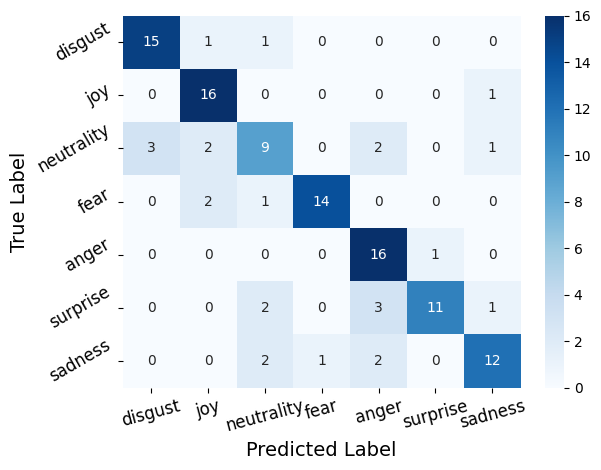

In [34]:
errors, y_true, y_pred = obtain_predictions(test, trained_ae)
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average ="weighted"))

obtain_cm(y_true, y_pred, lab)   

In [35]:
for t in test:
    print(trained_ae[0].predict(t)[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[1.6624658 7.8625417]
 [4.478716  5.6945953]
 [2.331556  7.6634736]
 [1.7535986 8.310038 ]
 [2.304643  7.411681 ]
 [2.435264  7.830896 ]
 [4.222226  5.6795163]
 [2.6512039 7.502506 ]
 [2.3689685 7.5837445]
 [3.6749866 6.6262465]
 [3.0052028 7.023316 ]
 [3.5052338 6.795359 ]
 [2.387247  7.9114003]
 [2.7767055 7.4946923]
 [1.7518482 8.368842 ]
 [1.852213  8.981976 ]
 [2.1721969 8.264346 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[8.94029   0.5091895]
 [8.131027  1.9881358]
 [7.044602  1.7876259]
 [8.008565  2.1641295]
 [5.712909  4.4780054]
 [7.7182455 2.4141014]
 [8.309592  1.6983194]
 [7.979591  1.760996 ]
 [7.84679   2.1278403]
 [8.019236  2.1186523]
 [8.602111  1.8480785]
 [8.0945425 2.012863 ]
 [7.963652  1.9260168]
 [7.872853  1.8707595]
 [7.783213  2.0812807]
 [8.850914  1.8369002]
 [8.204168  1.9282464]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[7.0347486 2.4773557]
 [8.380971  2.0726216]
 [7.8658013 2.031916 ]
 [7.924421  1.8344623]
 [6.34018 

In [36]:
encoders = []
for autoencoder in trained_ae:
    bottleneck_layer = autoencoder.layers[2]
    input_layer = autoencoder.layers[0]

    # Create a new model
    encoder = keras.Model(inputs=input_layer.output ,outputs=bottleneck_layer.output)
    encoders.append(encoder)


# for i,ae in enumerate(encoders):
#     name = "model/re_train/EMOVO_sig/ae_" + lab[i] + ".keras"
#     # name 
#     ae.save(name)

In [37]:
def get_representations(autoencoder_to_test, encoders, test):
    res = []
    lab = []
    for i in range(len(test)):
        res.append(encoders[autoencoder_to_test].predict(test[i], verbose = False)[-1])
        # print(len(test[i]))
        if i == autoencoder_to_test:
            lab.append([1]* len(test[i]))
        else:
            lab.append([0]* len(test[i]))

    features = np.concatenate(res, axis=0)
    labels = np.concatenate(lab, axis=0)
    return features, labels


In [38]:
tot_features = []
tot_labels = []
for i in range(len(trained_ae)):
    features, labels = get_representations(i, trained_ae, test)
    tot_features.append(features)
    tot_labels.append(labels)
# feat = features.reshape(-1,17,2)

In [39]:
tot_target = []
tot_non_target = []

for i in range(len(tot_features)): 

    data_array = tot_features[i]
    mask_array = tot_labels[i]

    tot_target.append(data_array[mask_array == 1])
    tot_non_target.append(data_array[~(mask_array == 1)])

# tot_target = np.array(tot_target)
# tot_non_target = np.array(tot_non_target)
t_features, averaged_1 = mean_diff(tot_target)
nt_features, averaged_2 = mean_diff(tot_non_target)

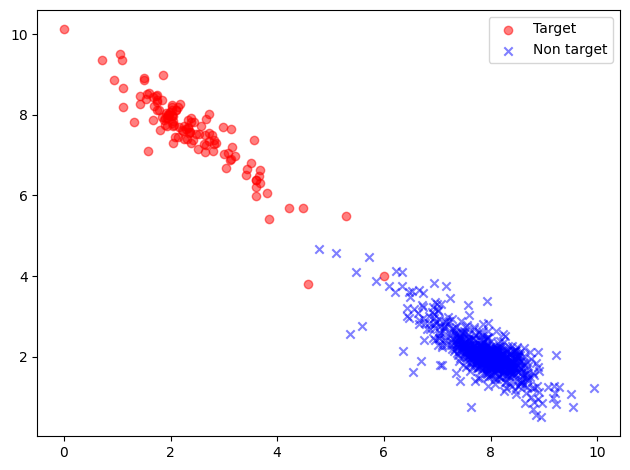

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

t_features = t_features.reshape(-1,2)
nt_features = nt_features.reshape(-1,2)

ax1.scatter(t_features[:,0], t_features[:,1], marker="o", color="red", alpha=0.5, label="Target")
ax1.scatter(nt_features[:,0], nt_features[:,1], marker="x", color="blue", alpha=0.5, label="Non target")

plt.legend()
plt.tight_layout()
# plt.savefig("DEMOS_OK.png")

In [19]:
features = np.concatenate([t_features, nt_features])
labels = np.concatenate([[1]*len(t_features), [0]*len(nt_features)])

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(features)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


In [21]:
features.shape, labels.shape

((833, 2), (833,))

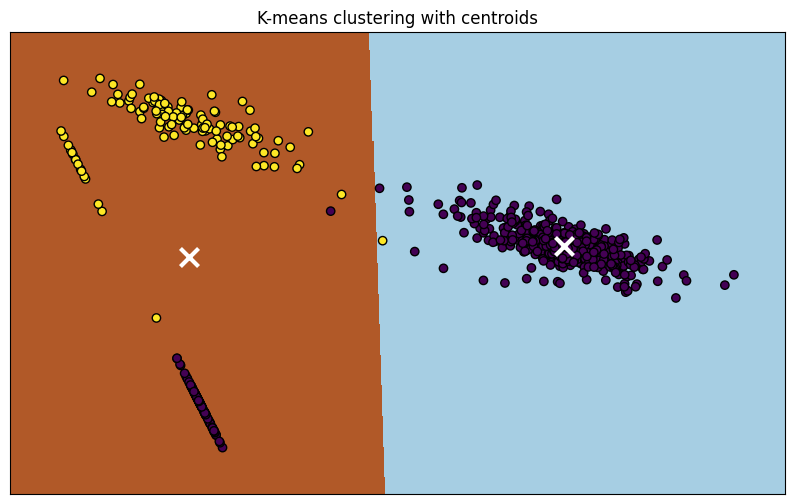

In [22]:
from sklearn.decomposition import PCA

# Apply PCA to the features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
model = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=1)

# THIS!
kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(float)

# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

# Plot the data points
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', edgecolor='k')

plt.title("K-means clustering with centroids")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 833 samples in 0.000s...
[t-SNE] Computed neighbors for 833 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 833 / 833
[t-SNE] Mean sigma: 0.111006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.194050
[t-SNE] KL divergence after 5000 iterations: 0.284563


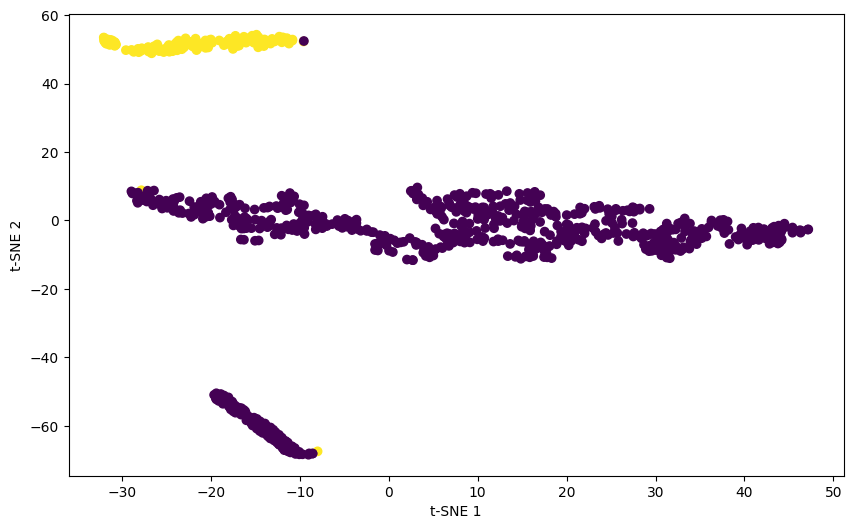

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=35, learning_rate="auto", init='pca', verbose=True, max_iter=5000)
tsne_features = tsne.fit_transform(features)
plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()